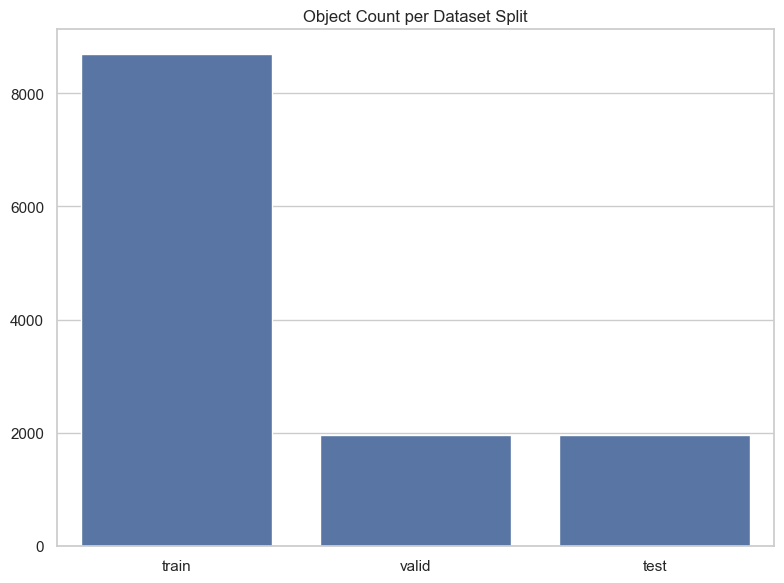

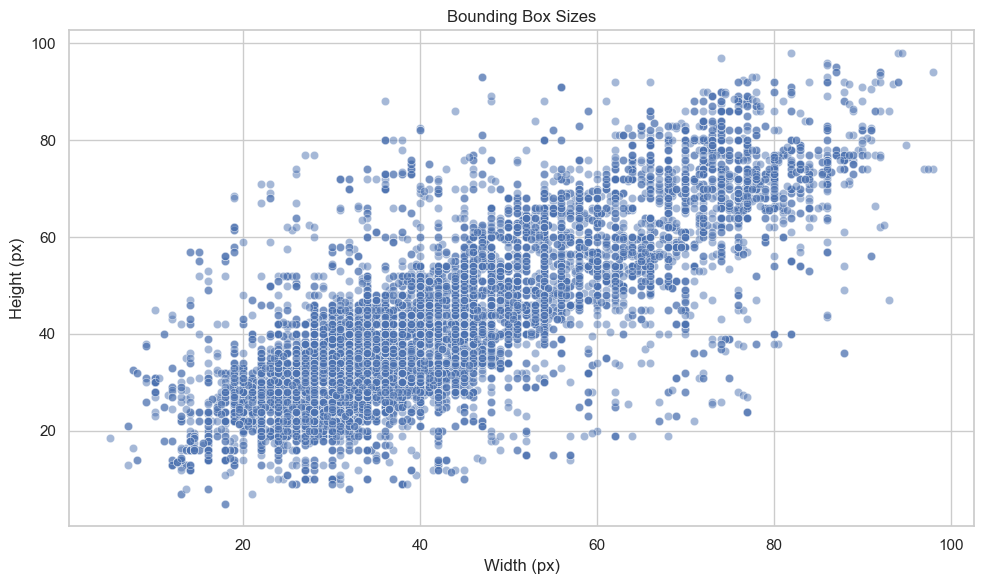

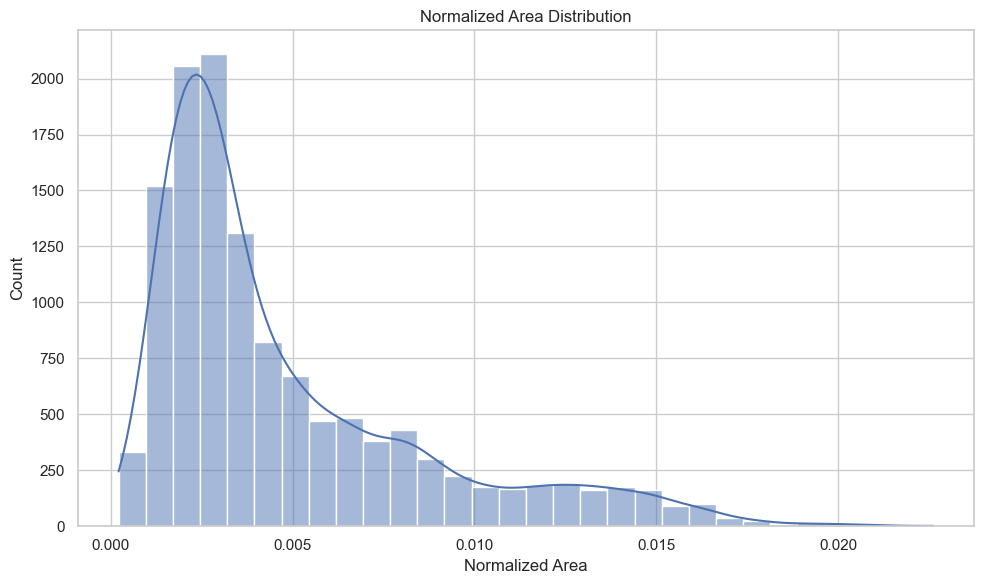

In [9]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

BASE_DIR = "dataset"
SPLITS = ["train", "valid", "test"]
IMG_EXTS = [".jpg", ".jpeg", ".png"]

class_names = ['Aircraft', 'ship', 'vehicle']

all_annotations = []

def get_image_path(image_name, image_dir):
  for ext in IMG_EXTS:
    path = os.path.join(image_dir, image_name + ext)
    if os.path.exists(path):
        return path
  return None

for split in SPLITS:
  label_dir = os.path.join(BASE_DIR, split, "labels")
  image_dir = os.path.join(BASE_DIR, split, "images")

  if not os.path.exists(label_dir):
    continue

  txt_files = glob.glob(os.path.join(label_dir, "*.txt"))

  for label_path in txt_files:
    base_name = os.path.splitext(os.path.basename(label_path))[0]
    img_path = get_image_path(base_name, image_dir)
    if not img_path:
      continue

    img = cv2.imread(img_path)
    if img is None:
      continue
    h_img, w_img = img.shape[:2]

    with open(label_path, "r") as f:
      for line in f:
        parts = line.strip().split()
        if len(parts) != 5:
          continue
        class_id, xc, yc, bw, bh = map(float, parts)
        annotation = {
          "split": split,
          "image": base_name,
          "class_id": int(class_id),
          "class_name": class_names[int(class_id)],
          "width": bw * w_img,
          "height": bh * h_img,
          "area": bw * bh,
        }
        all_annotations.append(annotation)

split_counts = {"train": 0, "valid": 0, "test": 0}
for ann in all_annotations:
  split_counts[ann["split"]] += 1

plt.figure(figsize=(8, 6))
sns.barplot(x=list(split_counts.keys()), y=list(split_counts.values()))
plt.title("Object Count per Dataset Split")
plt.tight_layout()
plt.savefig("objects_per_split.png")
plt.show()

widths = [ann["width"] for ann in all_annotations]
heights = [ann["height"] for ann in all_annotations]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.5)
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Bounding Box Sizes")
plt.tight_layout()
plt.savefig("bbox_sizes.png")
plt.show()

areas = [ann["area"] for ann in all_annotations]
plt.figure(figsize=(10, 6))
sns.histplot(areas, bins=30, kde=True)
plt.xlabel("Normalized Area")
plt.title("Normalized Area Distribution")
plt.tight_layout()
plt.savefig("area_distribution.png")
plt.show()


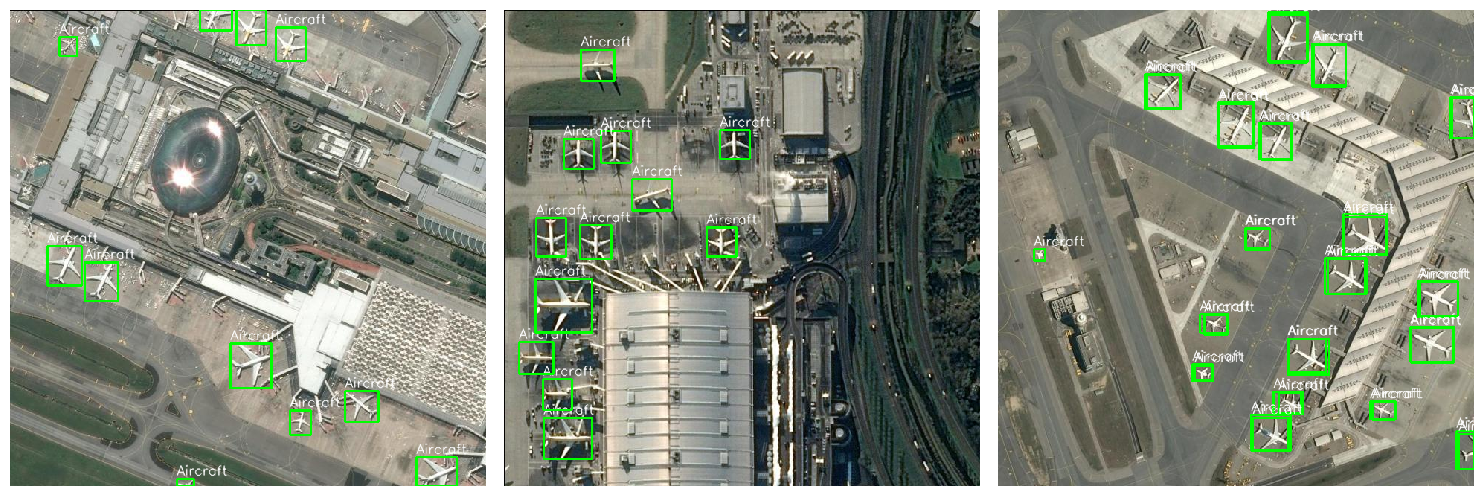

In [12]:
import random

def draw_bbox(image_path, label_path, class_names):
  image = cv2.imread(image_path)
  if image is None:
    return None
  h_img, w_img = image.shape[:2]

  with open(label_path, "r") as f:
    for line in f:
      parts = line.strip().split()
      if len(parts) != 5:
        continue
      class_id, xc, yc, bw, bh = map(float, parts)
      x1 = int((xc - bw / 2) * w_img)
      y1 = int((yc - bh / 2) * h_img)
      x2 = int((xc + bw / 2) * w_img)
      y2 = int((yc + bh / 2) * h_img)
      class_name = class_names[int(class_id)]

      cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.putText(image, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

NUM_SAMPLES = 3
sampled = random.sample(all_annotations, min(NUM_SAMPLES, len(all_annotations)))
shown = set()

plt.figure(figsize=(15, 8), dpi=100)
index = 1

for ann in sampled:
  key = (ann["split"], ann["image"])
  if key in shown:
    continue
  shown.add(key)

  img_path = get_image_path(ann["image"], os.path.join(BASE_DIR, ann["split"], "images"))
  label_path = os.path.join(BASE_DIR, ann["split"], "labels", ann["image"] + ".txt")

  img_with_boxes = draw_bbox(img_path, label_path, class_names)
  if img_with_boxes is not None:
    plt.subplot(1, NUM_SAMPLES, index)
    plt.imshow(img_with_boxes, interpolation='nearest')
    plt.axis('off')
    index += 1
  if index > NUM_SAMPLES:
    break

plt.tight_layout()
plt.savefig("sample_bboxes.png")
plt.show()
